<center>
<h1> Wilson The Cryptohamster </h1>
<h2>Trading Cryptocurrency with the Power of a cute Syrian Hamster</h2>
<hr>
<h1>Exploratory Data Analysis</h1>
<hr>
</center>

In this Notebook, we explore the raw data created from the hamster wheel sensor. The goals are as follows:

1. Determine the parameters used for the decision process (e.g., timeout between two wheel runs, speed, distance).
2. Find out how much Wilson travels on a usual night.

# Install dependencies

In [2]:
import hashlib
import pandas as pd

In [10]:
import hashlib
import pandas as pd

def add_hash_column(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """Add hash column to df based on columns."""
    df["hash"] = df[columns].astype(str).apply(lambda x: hashlib.md5(x.to_string().encode()).hexdigest(), axis=1)
    return df

In [11]:
df_decision_cycle = pd.DataFrame(
    {
        "some_col": ["A", "CCC", "BBB"],
        "type": ["currency", "buy_or_sell", "amount"],
        "result": ["BTC", "buy", 0.1],
        "start_time": [
            pd.Timestamp("2023-08-01 00:00:00"),
            pd.Timestamp("2023-08-02 00:00:03"),
            pd.Timestamp("2023-08-03 00:00:06"),
        ],
    }
)

In [12]:
df_decision_cycle

,some_col,type,result,start_time
0,A,currency,BTC,2023-08-01 00:00:00
1,CCC,buy_or_sell,buy,2023-08-02 00:00:03
2,BBB,amount,0.1,2023-08-03 00:00:06


In [13]:
add_hash_column(df=df_decision_cycle, columns=["result", "start_time", ])

,some_col,type,result,start_time,hash
0,A,currency,BTC,2023-08-01 00:00:00,d237caf3201fa7de9387139c5e43d46d
1,CCC,buy_or_sell,buy,2023-08-02 00:00:03,6bd39e4cb3e887712394d5194f2aff16
2,BBB,amount,0.1,2023-08-03 00:00:06,9cd29d4c390f0696cb85e395b9005c3b


In [3]:
#%pip install pandas numpy matplotlib seaborn pymysql

# Import libraries and constants

We also set the default dpi of figures a bit higher and tell pandas to ignore some warnings (setting with copy).

In [1]:
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymysql
import seaborn as sns
import sys
from typing import Tuple

# Add path to source files
sys.path.insert(1, os.path.join(sys.path[0], '..'))

def load_credentials(filepath: str) -> Tuple[str, str]:
    """Function to load credentials from a file.

    Args:
        filepath: Full file path to the credentials file.
    
    Returns:
        (user, password): Tuple of user and password strings.
    """
    with open(filepath) as f:
        lines = f.readlines()
        f.close()
    user = lines[0].split(':')[1].strip()
    password = lines[1].split(':')[1].strip()

    return (user, password)


# Constants
from src.python.constants import (
    DATABASE,
    HOST_REMOTE,
    PORT,
    TABLE_HAMSTERWHEEL,
)

matplotlib.rcParams['figure.dpi'] = 200
pd.options.mode.chained_assignment = None


# Connect to the MySQL Database

The database is running on the RPi.

In [36]:
# Load credentials to connect to the database
FULL_PATH_TO_CREDENTIALS = './../credentials.cred'
user, password = load_credentials(filepath=FULL_PATH_TO_CREDENTIALS)

# Create mysql connection
mysql_connection = pymysql.connect(
    host=HOST_REMOTE,
    user=user,
    password=password,
    db=DATABASE,
    port=PORT,
    charset='utf8'
)
print(type(mysql_connection))


<class 'pymysql.connections.Connection'>


In [37]:
query = f"SELECT * FROM TEST_wallet"
df = pd.read_sql(
    sql=query,
    con=mysql_connection,
    index_col='wallet_id'
)
mysql_connection.close()
df

,currency_symbol,amount
wallet_id,,
1,CASH,10000.0
2,BTC,9999.0


In [45]:
wallet = {}
for item in df.iterrows():
    wallet[item[1]['currency_symbol']] = item[1]['amount']

In [46]:
wallet

{'CASH': 10000.0, 'BTC': 9999.0}

In [14]:
a = df.iloc[-3:, :]
m = a['type'] == 'amount'
a.loc[m, :].loc[:, 'result'].values[0]

'44'

In [24]:
df

,session_id,type,result,start_time,end_time,hamsterwheel_id_start,hamsterwheel_id_end,wheel_turns
decision_id,,,,,,,,
1,1,buy_sell,SELL,2022-06-29 21:19:57.194496,2022-06-29 21:20:09.668662,1488,1499,0
2,1,currency,eth,2022-06-29 21:20:39.937058,2022-06-29 21:20:49.402386,1503,1510,0
3,1,amount,100,2022-06-29 21:21:27.857066,2022-06-29 21:22:26.266960,1513,1522,0
4,1,buy_sell,SELL,2022-06-29 21:22:45.005309,2022-06-29 21:22:52.315279,1525,1530,0
5,1,currency,eth,2022-06-29 21:22:56.526622,2022-06-29 21:22:58.644119,1533,1534,0
6,1,amount,100,2022-06-29 21:23:03.853632,2022-06-29 21:23:08.017311,1537,1539,0
7,1,buy_sell,SELL,2022-06-29 21:23:11.142511,2022-06-29 21:23:26.022293,1543,1556,0
8,1,currency,eth,2022-06-29 21:23:58.260547,2022-06-29 21:24:48.109928,1559,1567,0
9,1,amount,100,2022-06-29 21:24:57.485462,2022-06-29 21:25:55.292323,1570,1587,0


In [10]:
query = f"SELECT * FROM TEST_hamsterwheel"
df = pd.read_sql(
    sql=query,
    con=mysql_connection,
    index_col='hamsterwheel_id'
)
mysql_connection.close()

c:\Users\heiko\OneDrive\01_Projects\31.WilsonCrypto\repo\cryptohamster\env\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


# Check data in the hamsterwheel table

The `hamsterhweel` table contains all the measurements where the magnetic sensor triggered a close. The absence of a record in the database means that the sensor was open. 

In [7]:
query = f"SELECT * FROM {TABLE_HAMSTERWHEEL}"
df = pd.read_sql(
    sql=query,
    con=mysql_connection,
    index_col='hamsterwheel_id'
)

c:\Users\heiko\OneDrive\01_Projects\31.WilsonCrypto\repo\cryptohamster\env\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Let's see what the data type is in the table. The time is stored as a datetime object, the flag (is always 1 by default) is an integer.

In [8]:
df.dtypes

time    datetime64[ns]
flag             int64
dtype: object

Sorting by the time in descending order shows the latest measurement.

In [9]:
df.sort_values(by=['time'], ascending=False).head()

,time,flag
hamsterwheel_id,,
241185,2022-06-26 01:26:39.968401,1
241184,2022-06-26 01:26:39.946706,1
241183,2022-06-26 01:26:39.925458,1
241182,2022-06-26 01:26:38.089160,1
241181,2022-06-26 01:26:38.057198,1


## Distribution of time between two consecutive readings

Let's calculate the difference between two readings of the magnetic sensor. That gives an idea how fast the hamster is usually running. Very long differences mean that the hamster did not run, but the last reading when it stepped of the wheel and the first when it stepped back on. This approach cannot distinguish between two events where the hamster is just running slow and when it stops and steps back on.

In [10]:
df['diff'] = (df['time'] - df['time'].shift(1))
df['diff_s'] = df['diff'].dt.total_seconds()
print(df.shape)
df.head()

(241185, 4)


,time,flag,diff,diff_s
hamsterwheel_id,,,,
1,2022-05-31 21:27:47.173574,1,NaT,NaN
2,2022-05-31 21:27:47.189967,1,0 days 00:00:00.016393,0.016393
3,2022-05-31 21:27:47.211610,1,0 days 00:00:00.021643,0.021643
4,2022-05-31 21:27:47.236608,1,0 days 00:00:00.024998,0.024998
5,2022-05-31 21:31:26.219387,1,0 days 00:03:38.982779,218.982779


When plotting the native distances as a boxplot, we see that there are a lot of high frequencies and a few long ones. The former - high frequencies - means that the magnetic sensor recorded multiple times a closure when the magnet was passing over it. The very low frequencies (long times between readings) can also be ignored, because here the hamster was not running in the wheel.

Let's further refine the plot with a maximum and minimum threshold for the difference in seconds: 0.8 and 12 seconds, respectively.

<AxesSubplot:xlabel='diff_s'>

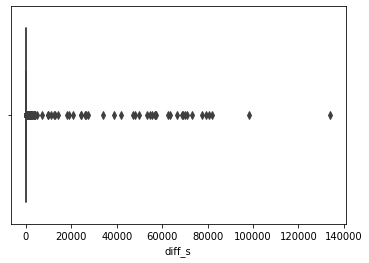

In [11]:
sns.boxplot(x=df['diff_s'])

<AxesSubplot:xlabel='diff_s'>

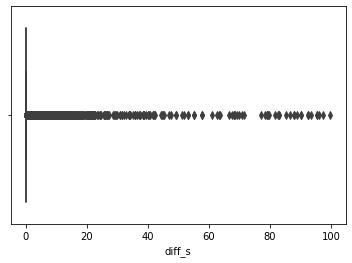

In [12]:
sns.boxplot(x=df.loc[df['diff_s'] < 100,'diff_s'])

In [13]:
min_threshold = 0.2
max_threshold = 12

m = (df['diff_s'] < max_threshold) & (df['diff_s'] > min_threshold)
df_cleaned = df.loc[m]

n_rem = df.shape[0] - df_cleaned.shape[0]
print(f"We removed {n_rem} rows by filtering on small and long time differences between wheel readings.")


We removed 219301 rows by filtering on small and long time differences between wheel readings.


Let's plot this new distribution.

What we see is that the hamster takes about 1.2 to 2.2 seconds most times when it is running in the wheel. There might be some occasions when it's running much slower (thus more time between readings). As mentioned before, there's no way from the data alone to distinguish between the hamster running very slowly and running and stepping of from the wheel and after a few seconds stepping back on. At least not with the method used to determine the speed in this project.

However, that all being said, for our purposes, this will do just fine.


Text(0.5, 0, 'Difference between consecutive readings in seconds')

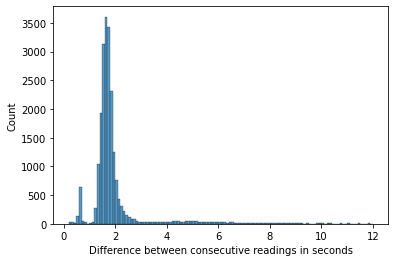

In [14]:
sns.histplot(data=df_cleaned, x='diff_s', binwidth=0.1)
plt.xlabel('Difference between consecutive readings in seconds')

Text(0.5, 0, 'Difference between consecutive readings in seconds')

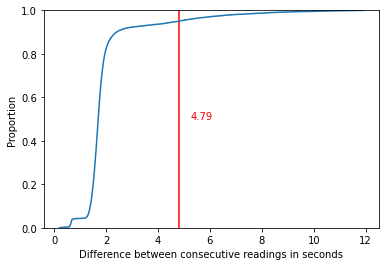

In [15]:
# Lets see where 95% of the data points fall
x_95 = df_cleaned['diff_s'].quantile(.95)

plt.axvline(x_95, color='red')
plt.text(x_95*1.1, 0.5, s=f'{np.round(x_95, 2)}', color='red')

sns.ecdfplot(data=df_cleaned, x='diff_s')
plt.xlabel('Difference between consecutive readings in seconds')


Going back to why we did this investigation in the first place, we wanted to determine the parameters used for the decision process (e.g., timeout between two wheel runs, speed, distance)*. From the data, we conclude the following:

We set the timeout between wheel runs to 3.8 seconds. I.e., if the hamster steps back on the wheel within 5 seconds, any decision timer continues to run. If the hamster steps off for more than 3.8 seconds, the decision timer ends and locks a decision in. Again, this approach cannot distinguish between "slow running" and "stepping off the wheel and back on".

# Determine the speed of the hamster and distance traveled

Let's for a typical night determine how fast and how far the hamster is running.

In [16]:
WHEELSIZE = 30  # cm
last_30s = df_cleaned[ df_cleaned['time'] >= datetime.now() - pd.Timedelta(seconds=30)]
last_30s


,time,flag,diff,diff_s
hamsterwheel_id,,,,


In [17]:
# mean time diff
time_diff = last_30s['diff_s'].mean()
speed_cm_s = WHEELSIZE * 2 * np.pi/time_diff
speed_km_h = 60*60*speed_cm_s/100/1000
speed_km_h

nan

In [18]:
distance = WHEELSIZE * 2 * np.pi
df_cleaned['avg_speed'] = distance/df_cleaned['diff_s'].rolling(5).mean()
# convert to km/h
df_cleaned['avg_speed'] = 60*60*df_cleaned['avg_speed']/100/1000

In [19]:
df_cleaned

,time,flag,diff,diff_s,avg_speed
hamsterwheel_id,,,,,
7,2022-05-31 21:31:31.370770,1,0 days 00:00:05.135326,5.135326,NaN
10,2022-05-31 21:31:33.465190,1,0 days 00:00:02.051821,2.051821,NaN
12,2022-05-31 21:31:35.643069,1,0 days 00:00:02.156843,2.156843,NaN
14,2022-05-31 21:31:37.790426,1,0 days 00:00:02.126198,2.126198,NaN
17,2022-05-31 21:32:00.884976,1,0 days 00:00:01.744236,1.744236,2.567588
...,...,...,...,...,...
241173,2022-06-26 01:26:32.284103,1,0 days 00:00:01.765799,1.765799,2.498369
241176,2022-06-26 01:26:34.172728,1,0 days 00:00:01.845821,1.845821,2.951612
241179,2022-06-26 01:26:36.060824,1,0 days 00:00:01.844631,1.844631,3.586937


<AxesSubplot:xlabel='time'>

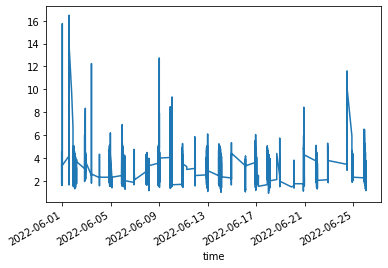

In [20]:
plot_speed = df_cleaned.set_index('time')
plot_speed.loc['2022-05-31 22:38:00': ,'avg_speed'].plot()

<AxesSubplot:xlabel='time'>

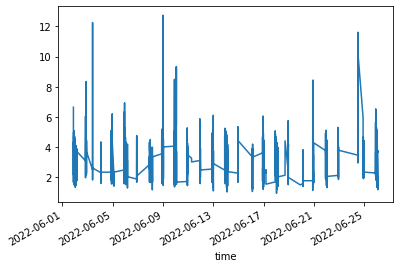

In [21]:
plot_speed = df_cleaned.set_index('time')
plot_speed.loc['2022-06-01 20:00 21:00:00': ,'avg_speed'].plot()

<AxesSubplot:xlabel='time'>

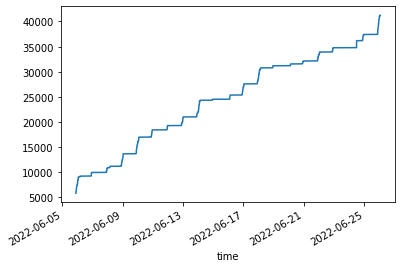

In [22]:
# distance in m
df_cleaned['distance'] = df_cleaned.reset_index().index * WHEELSIZE * np.pi * 2 / 100
plot_speed = df_cleaned.set_index('time')
plot_speed.loc['2022-06-05 20:00':,'distance'].plot()

In [23]:
df_cleaned

,time,flag,diff,diff_s,avg_speed,distance
hamsterwheel_id,,,,,,
7,2022-05-31 21:31:31.370770,1,0 days 00:00:05.135326,5.135326,NaN,0.000000
10,2022-05-31 21:31:33.465190,1,0 days 00:00:02.051821,2.051821,NaN,1.884956
12,2022-05-31 21:31:35.643069,1,0 days 00:00:02.156843,2.156843,NaN,3.769911
14,2022-05-31 21:31:37.790426,1,0 days 00:00:02.126198,2.126198,NaN,5.654867
17,2022-05-31 21:32:00.884976,1,0 days 00:00:01.744236,1.744236,2.567588,7.539822
...,...,...,...,...,...,...
241173,2022-06-26 01:26:32.284103,1,0 days 00:00:01.765799,1.765799,2.498369,41240.943401
241176,2022-06-26 01:26:34.172728,1,0 days 00:00:01.845821,1.845821,2.951612,41242.828356
241179,2022-06-26 01:26:36.060824,1,0 days 00:00:01.844631,1.844631,3.586937,41244.713312


Wilson ran 3402.34 m between 2022-06-05 20:00 and 2022-06-06 12:00


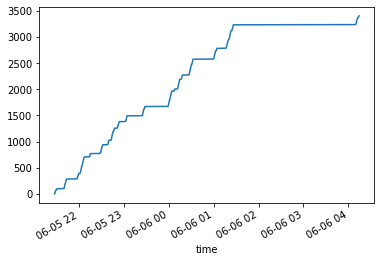

In [24]:
# distance in m
start = '2022-06-05 20:00'
end = '2022-06-06 12:00'

df_day = df_cleaned.set_index('time').loc[start:end, :]
df_day['distance'] = df_day.reset_index().index * WHEELSIZE * np.pi * 2 / 100

df_day.loc[:,'distance'].plot()
daily_distance = df_day['distance'].iloc[-1]
print(f'Wilson ran {daily_distance:.2f} m between {start} and {end}')

Wilson ran 725.71 m between 2022-06-06 20:00 and 2022-06-07 12:00


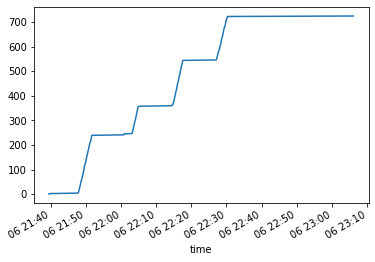

In [25]:
# distance in m
start = '2022-06-06 20:00'
end = '2022-06-07 12:00'

df_day = df_cleaned.set_index('time').loc[start:end, :]
df_day['distance'] = df_day.reset_index().index * WHEELSIZE * np.pi * 2 / 100

df_day.loc[:,'distance'].plot()
daily_distance = df_day['distance'].iloc[-1]
print(f'Wilson ran {daily_distance:.2f} m between {start} and {end}')

Wilson ran 1228.99 m between 2022-06-07 20:00 and 2022-06-08 12:00


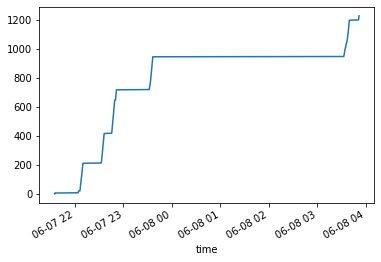

In [26]:
# distance in m
start = '2022-06-07 20:00'
end = '2022-06-08 12:00'

df_day = df_cleaned.set_index('time').loc[start:end, :]
df_day['distance'] = df_day.reset_index().index * WHEELSIZE * np.pi * 2 / 100

df_day.loc[:,'distance'].plot()
daily_distance = df_day['distance'].iloc[-1]
print(f'Wilson ran {daily_distance:.2f} m between {start} and {end}')

Wilson ran 2474.95 m between 2022-06-08 20:00 and 2022-06-09 12:00


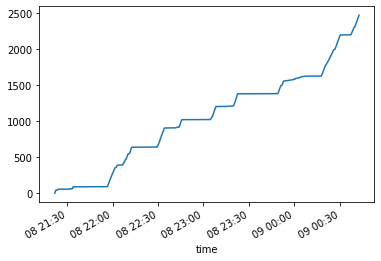

In [27]:
# distance in m
start = '2022-06-08 20:00'
end = '2022-06-09 12:00'

df_day = df_cleaned.set_index('time').loc[start:end, :]
df_day['distance'] = df_day.reset_index().index * WHEELSIZE * np.pi * 2 / 100

df_day.loc[:,'distance'].plot()
daily_distance = df_day['distance'].iloc[-1]
print(f'Wilson ran {daily_distance:.2f} m between {start} and {end}')

Wilson ran 3319.41 m between 2022-06-09 20:00 and 2022-06-10 12:00


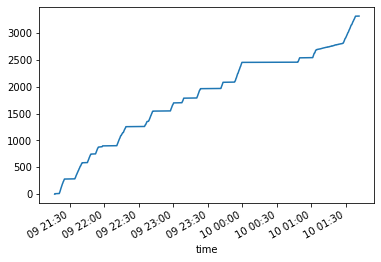

In [28]:
# distance in m
start = '2022-06-09 20:00'
end = '2022-06-10 12:00'

df_day = df_cleaned.set_index('time').loc[start:end, :]
df_day['distance'] = df_day.reset_index().index * WHEELSIZE * np.pi * 2 / 100

df_day.loc[:,'distance'].plot()
daily_distance = df_day['distance'].iloc[-1]
print(f'Wilson ran {daily_distance:.2f} m between {start} and {end}')

Wilson ran 1438.22 m between 2022-06-10 20:00 and 2022-06-11 12:00


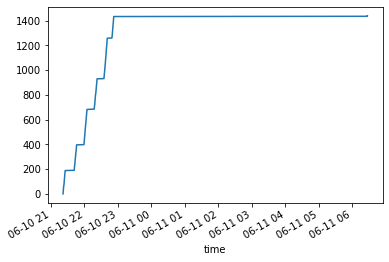

In [29]:
# distance in m
start = '2022-06-10 20:00'
end = '2022-06-11 12:00'

df_day = df_cleaned.set_index('time').loc[start:end, :]
df_day['distance'] = df_day.reset_index().index * WHEELSIZE * np.pi * 2 / 100

df_day.loc[:,'distance'].plot()
daily_distance = df_day['distance'].iloc[-1]
print(f'Wilson ran {daily_distance:.2f} m between {start} and {end}')

Wilson ran 853.88 m between 2022-06-11 20:00 and 2022-06-12 12:00


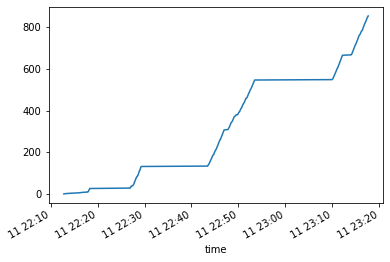

In [30]:
# distance in m
start = '2022-06-11 20:00'
end = '2022-06-12 12:00'

df_day = df_cleaned.set_index('time').loc[start:end, :]
df_day['distance'] = df_day.reset_index().index * WHEELSIZE * np.pi * 2 / 100

df_day.loc[:,'distance'].plot()
daily_distance = df_day['distance'].iloc[-1]
print(f'Wilson ran {daily_distance:.2f} m between {start} and {end}')

Wilson ran 1719.08 m between 2022-06-12 20:00 and 2022-06-13 12:00


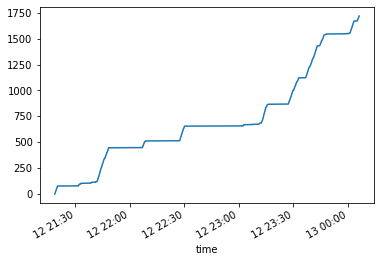

In [31]:
# distance in m
start = '2022-06-12 20:00'
end = '2022-06-13 12:00'

df_day = df_cleaned.set_index('time').loc[start:end, :]
df_day['distance'] = df_day.reset_index().index * WHEELSIZE * np.pi * 2 / 100

df_day.loc[:,'distance'].plot()
daily_distance = df_day['distance'].iloc[-1]
print(f'Wilson ran {daily_distance:.2f} m between {start} and {end}')

Wilson ran 358.14 m between 2022-06-19 20:00 and 2022-06-20 12:00


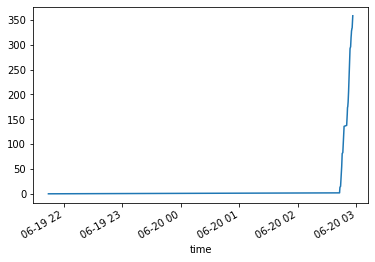

In [32]:
# distance in m
start = '2022-06-19 20:00'
end = '2022-06-20 12:00'

df_day = df_cleaned.set_index('time').loc[start:end, :]
df_day['distance'] = df_day.reset_index().index * WHEELSIZE * np.pi * 2 / 100

df_day.loc[:,'distance'].plot()
daily_distance = df_day['distance'].iloc[-1]
print(f'Wilson ran {daily_distance:.2f} m between {start} and {end}')

In [35]:
l = []
l.append(1)
l.append(2)
l.append(3)
l

[1, 2, 3]

In [36]:
l.pop(0)

1

In [37]:
l

[2, 3]

In [38]:
l.append(4)

In [39]:
l

[2, 3, 4]

In [44]:
type(df.index[-1])

numpy.int64

In [45]:
def add_l(item):
    l.append(item)

l

[2, 3, 4]

In [46]:
add_l(10)
l

[2, 3, 4, 10]

In [140]:
hamsterwheel_readings = []

def is_hamster_running(
    latest_hamsterwheel: pd.core.series.Series,
    ) -> bool:
    """Function to determine if the hamster is running or not.
    
    Args:
        latest_hamsterwheel: Latest reading of the hamsterwheel id table.
    
    Returns:
        True if last three readings in the while Loop are different, False otherwise.
    """
    latest_id = latest_hamsterwheel.name

    if len(hamsterwheel_readings) == 3:
        # 3 readings acquired
        if (hamsterwheel_readings[0] < hamsterwheel_readings[1]) & (hamsterwheel_readings[1] < hamsterwheel_readings[2]):
            # Add the next reading
            hamsterwheel_readings.pop(0)
            hamsterwheel_readings.append(latest_id)
            return True
        else:
            hamsterwheel_readings.pop(0)
            hamsterwheel_readings.append(latest_id)
            return False
    elif len(hamsterwheel_readings) < 3:
        # Keep populating the list
        hamsterwheel_readings.append(latest_id)
        return False

In [50]:
a = df.iloc[-1, :]

In [146]:
a = pd.Series(name=5)
is_hamster_running(a), hamsterwheel_readings

C:\Users\heiko\AppData\Local\Temp\ipykernel_11664\1957796645.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  a = pd.Series(name=5)


(False, [3, 4, 5])

In [133]:
hamsterwheel_readings

[3, 4, 4]

In [59]:
a

time      2022-06-26 01:26:39.968401
flag                               1
diff          0 days 00:00:00.021695
diff_s                      0.021695
Name: 241185, dtype: object

In [61]:
pd.Series(name=241186).name

C:\Users\heiko\AppData\Local\Temp\ipykernel_11664\3797436423.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(name=241186).name


241186